In [6]:
pip install scipy --upgrade


Note: you may need to restart the kernel to use updated packages.


In [262]:
from scipy import stats
from scipy.stats import skew,norm 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
sns.set()
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

#ML Algoirthm
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
#from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import xgboost


In [263]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_size = train.shape[0]
import warnings
warnings.filterwarnings(action="ignore")
train_size

1460

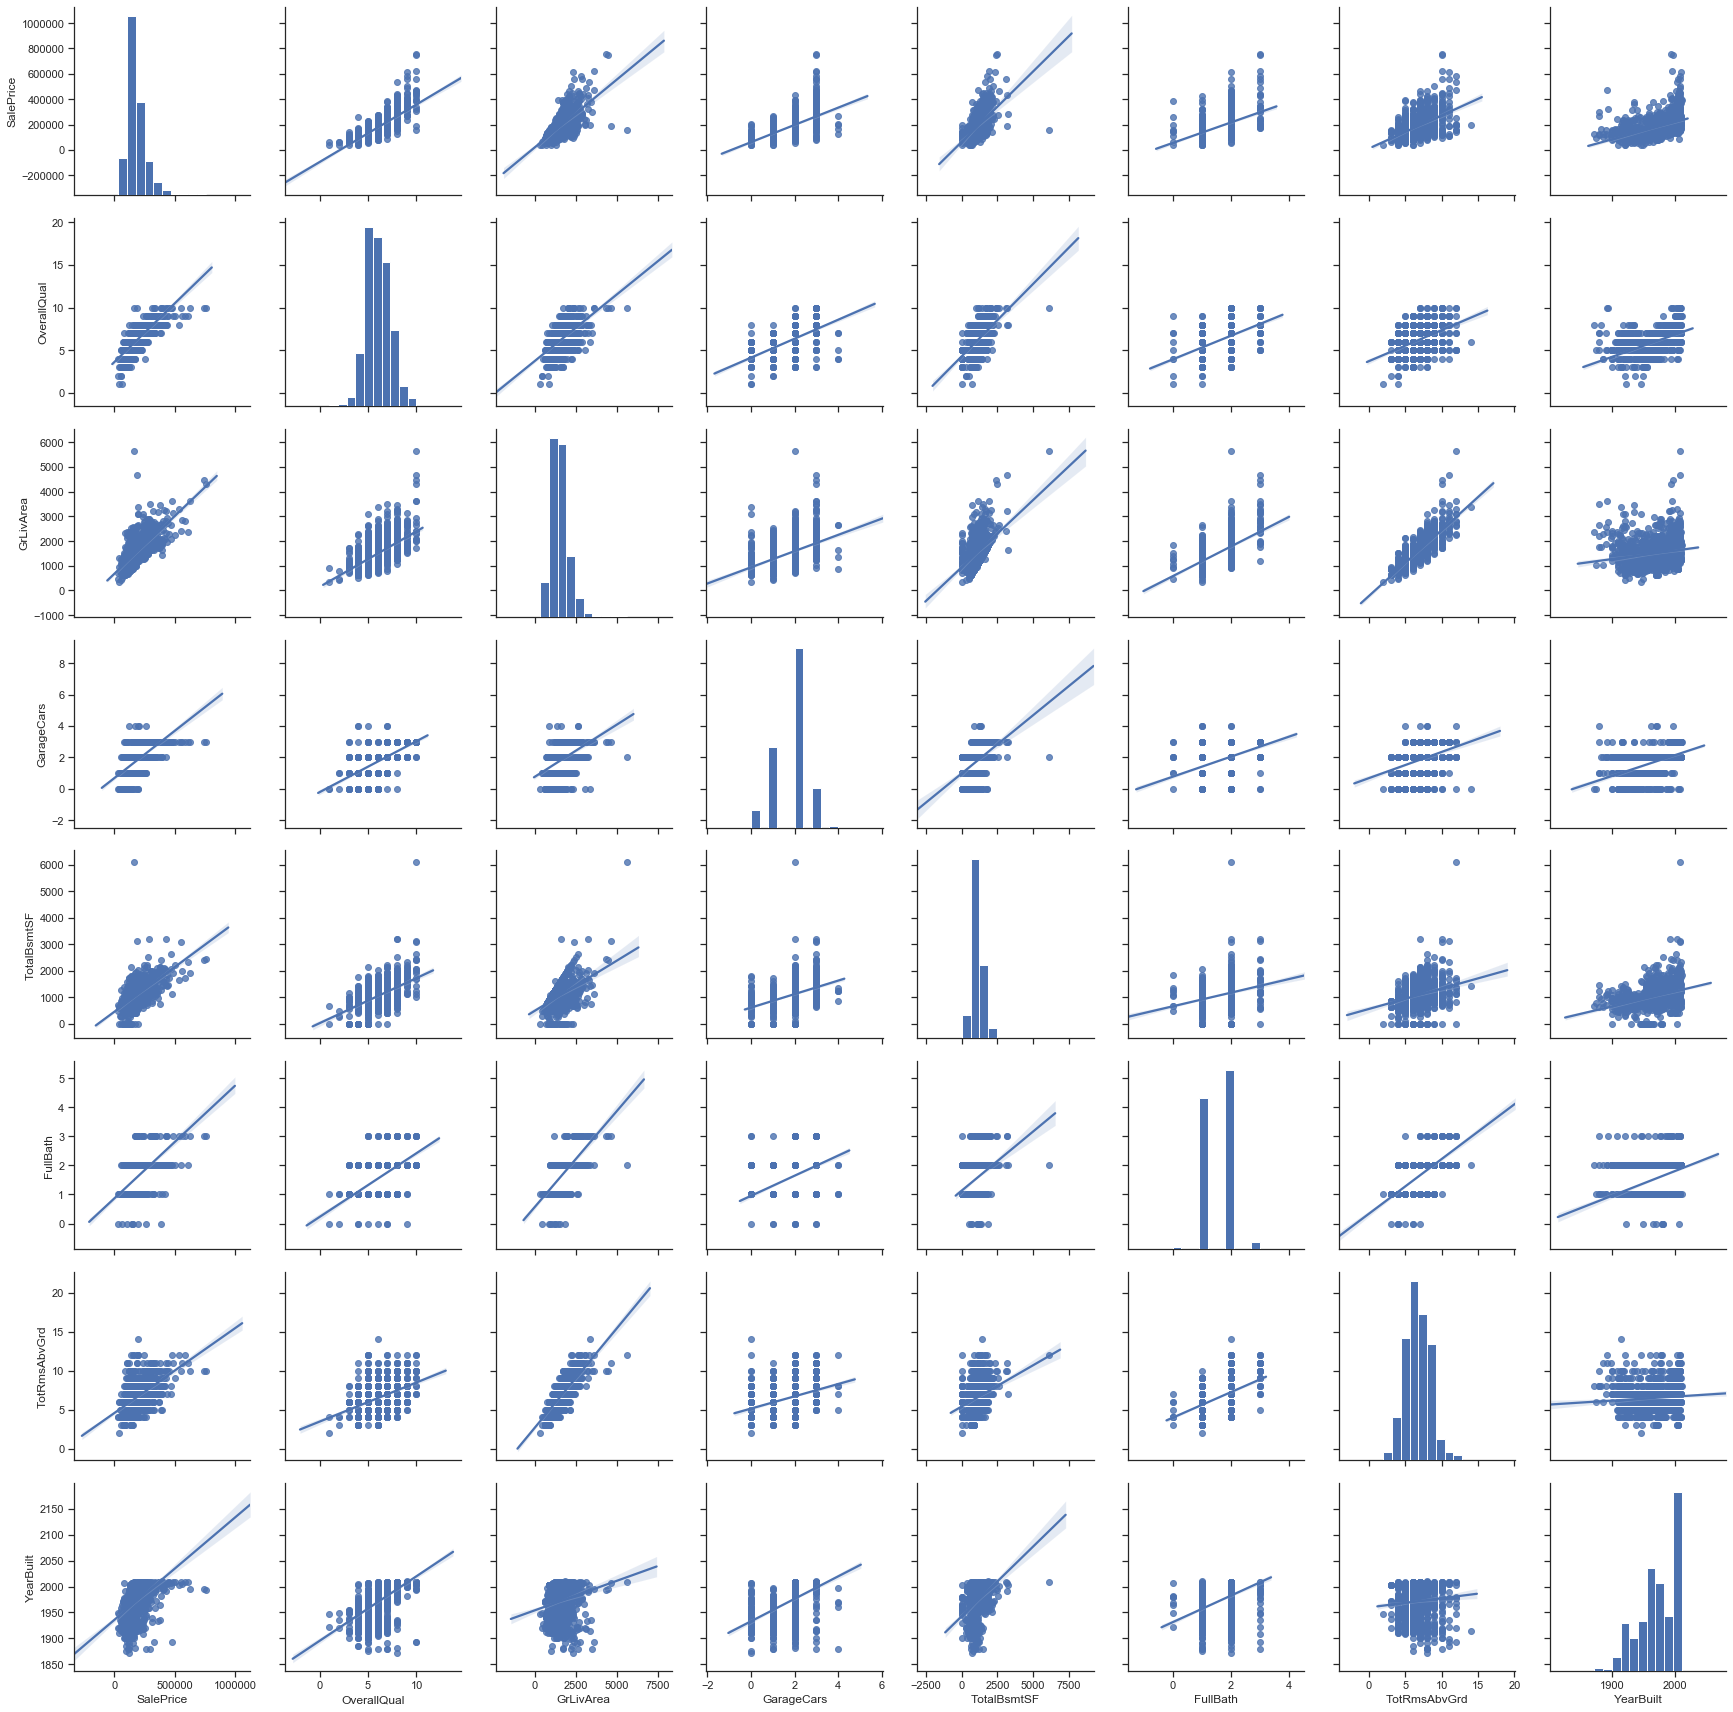

In [264]:
col = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.set(style='ticks')
sns.pairplot(train[col], height=3, kind='reg')

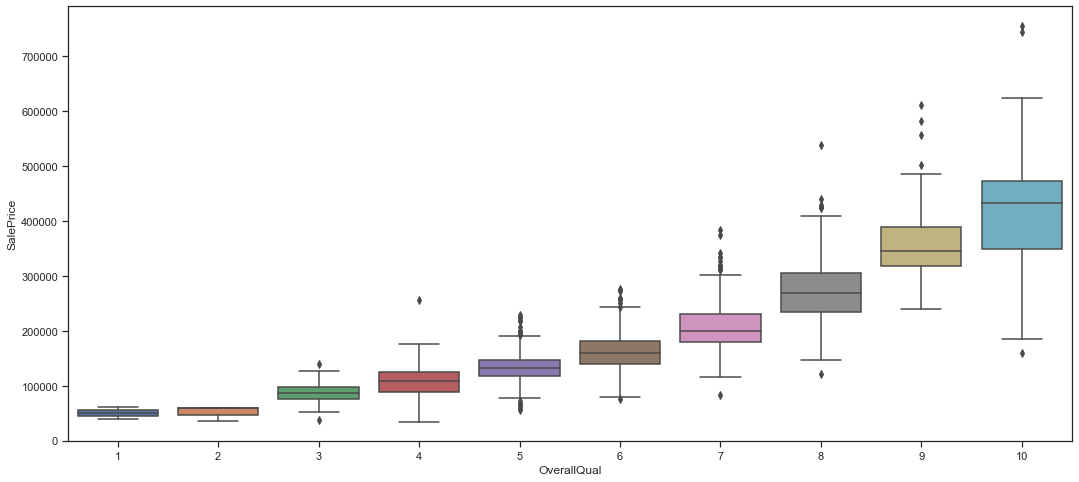

In [275]:
#boxplot
plt.figure(figsize=(18, 8))
sns.boxplot(x=train.OverallQual, y=train.SalePrice)

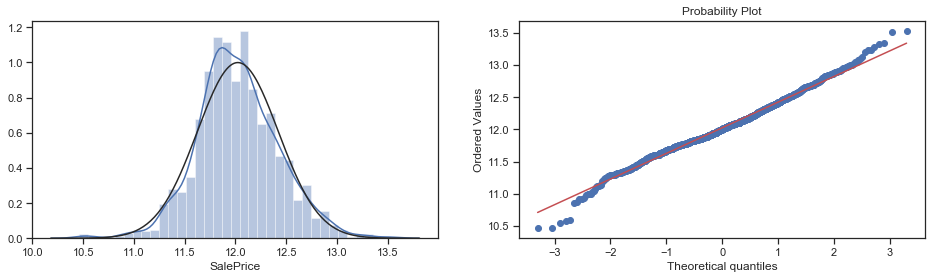

Skewness of log saleprice0.12134661989685329
skewness of sales price: 1.8828757597682129
Kurtosis: 0.809519155707878
Kurtosis: 0.809519155707878


In [265]:
#Log - transformation
y = np.log1p(train['SalePrice'])

f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness of log saleprice{}".format(y.skew()))
print("skewness of sales price: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(y.kurt()))
print("Kurtosis: {}".format(y.kurt()))


In [266]:
def remove_overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = remove_overfit_features(train,99)
print(overfitted_features)

#train.drop(overfitted_features,inplace=True,axis=1)
#test.drop(overfitted_features,inplace=True,axis=1)
print(train.shape)
print(test.shape)

['Street', 'Utilities', 'PoolArea']
(1460, 81)
(1459, 80)


In [267]:
train.drop(['Street','Utilities'],inplace=True,axis=1)
test.drop(['Street','Utilities'],inplace=True,axis=1)


In [268]:
print(train.shape)
print(test.shape)

(1460, 79)
(1459, 78)


In [269]:
train_labels = y
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(all_features.shape)
train_labels

(2919, 78)


0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [270]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [271]:
all_features.drop('Id',inplace=True,axis=1)
all_features.shape

(2919, 77)

# Impute the missing values

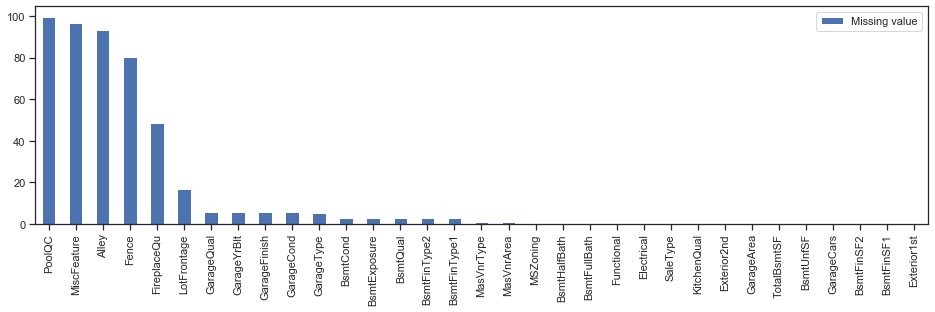

In [272]:
#visualize missing data
missing_value = all_features.isnull().sum().sort_values(ascending=False) / len(all_features) * 100
missing_value = missing_value[missing_value != 0]
missing_value = pd.DataFrame({'Missing value' :missing_value,'Type':missing_value.index.map(lambda x:all_features[x].dtype)})
missing_value.plot(kind='bar',figsize=(16,4))
plt.show()

In [273]:
print("Total No. of missing value {} before Imputation".format(sum(all_features.isnull().sum())))
def fill_missing_values():
 
    fillSaleType = all_features[all_features['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
    all_features['SaleType'].fillna(fillSaleType,inplace=True)

    fillElectrical = all_features[all_features['Neighborhood']=='Timber']['Electrical'].mode()[0]
    all_features['Electrical'].fillna(fillElectrical,inplace=True)

    exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
    fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior1st'].fillna(fillExterior1,inplace=True)
    print(all_features.shape)
    exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
    fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)
    
    bsmtNeigh = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
    fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
    all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)
    print(all_features.shape)
    kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
    fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
    all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)
        
    all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    print(all_features.shape)   
    all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2','PoolQC']:
        all_features[col] = all_features[col].fillna('None')
    
    categorical_cols =  all_features.select_dtypes(include='object').columns
    all_features[categorical_cols] = all_features[categorical_cols].fillna('None')
    
    numeric_cols = all_features.select_dtypes(include='number').columns
    all_features[numeric_cols] = all_features[numeric_cols].fillna(0)
    
    #all_features['Shed'] = np.where(all_features['MiscFeature']=='Shed', 1, 0)
    all_features['Shed_Area'] = all_features['MiscVal']
    #GarageYrBlt -  missing values there for the building which has no Garage, imputing 0 makes huge difference with other buildings,
    #imputing mean doesn't make sense since there is no Garage. So we'll drop it
    all_features.drop(['GarageYrBlt','MiscFeature','MiscVal','MSSubClass'],inplace=True,axis=1)
    print(all_features.shape)
   # all_features['QualitySF'] = all_features['GrLivArea'] * all_features['OverallQual']

fill_missing_values()

print("Total No. of missing value {} after Imputation".format(sum(all_features.isnull().sum())))

Total No. of missing value 13963 before Imputation
(2919, 77)
(2919, 77)
(2919, 77)
(2919, 74)
Total No. of missing value 0 after Imputation


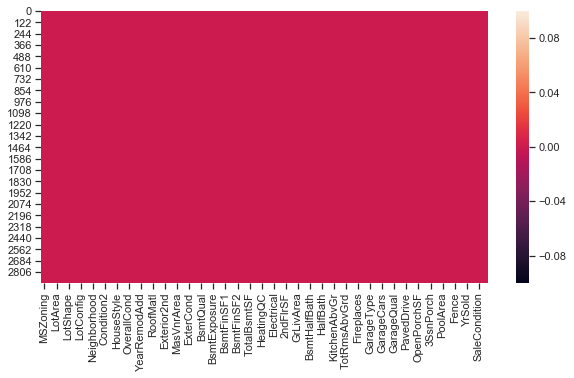

In [274]:
#Checking there is any null value or not
plt.figure(figsize=(10, 5))
sns.heatmap(all_features.isnull())

In [232]:
all_features = all_features.drop(['PoolQC',], axis=1)
all_features = all_features.drop(['MoSold',], axis=1)
all_features = all_features.drop(['YrSold',], axis=1)
all_features = all_features.drop(['BsmtFinSF2',], axis=1)


all_features = all_features.drop(['BsmtUnfSF',], axis=1)
all_features = all_features.drop(['BsmtFinSF1',], axis=1)
all_features = all_features.drop(['GarageCars',], axis=1)



# Fix skewed features

In [233]:
#converting some numeric features to string
#all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
#all_features['YrSold'] = all_features['YrSold'].astype(str)
#all_features['MoSold'] = all_features['MoSold'].astype(str)


# Filter the skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
high_skew1 = skew_features[skew_features <- 0.5]

skew_index = high_skew.index,high_skew1.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skewness)


There are 22 numerical features with Skew > 0.5 :
                    Skew
Shed_Area      21.947195
PoolArea       16.898328
LotArea        12.822431
LowQualFinSF   12.088761
3SsnPorch      11.376065
KitchenAbvGr    4.302254
EnclosedPorch   4.003891
ScreenPorch     3.946694
BsmtHalfBath    3.931594
MasVnrArea      2.613592
OpenPorchSF     2.535114
WoodDeckSF      1.842433
LotFrontage     1.505704
1stFlrSF        1.469604
GrLivArea       1.269358
TotalBsmtSF     1.156894
2ndFlrSF        0.861675
TotRmsAbvGrd    0.758367
Fireplaces      0.733495
HalfBath        0.694566
BsmtFullBath    0.624832
OverallCond     0.570312


In [234]:
def corr(df):
    df=df.corr(method ='pearson')
    return df

df=corr(train)
df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [235]:
len(all_features.columns)

67

In [236]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

TypeError: No loop matching the specified signature and casting
was found for ufunc add

In [237]:
#all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['OverallQual',], axis=1)
all_features = all_features.drop(['OverallCond',], axis=1)


all_features['TotalSF'] = all_features['GrLivArea'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features = all_features.drop(['GrLivArea',], axis=1)
all_features = all_features.drop(['1stFlrSF',], axis=1)
all_features = all_features.drop(['2ndFlrSF',], axis=1)


#all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']
#all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
#all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
 #                                all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features = all_features.drop(['FullBath',], axis=1)
all_features = all_features.drop(['HalfBath',], axis=1)
all_features = all_features.drop(['BsmtFullBath',], axis=1)
all_features = all_features.drop(['BsmtHalfBath',], axis=1)





all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features = all_features.drop(['OpenPorchSF',], axis=1)
all_features = all_features.drop(['3SsnPorch',], axis=1)
all_features = all_features.drop(['EnclosedPorch',], axis=1)
all_features = all_features.drop(['ScreenPorch',], axis=1)
all_features = all_features.drop(['WoodDeckSF',], axis=1)


all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
#all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
#all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
print(all_features.shape)

(2919, 57)


In [238]:
def logs(columns):
    for col in columns:
        all_features[col+"_log"] = np.log(1.01+all_features[col]) 
        print(all_features.shape)

log_features = ['Shed_Area','PoolArea','LotFrontage','LotArea','MasVnrArea',
                 'TotalBsmtSF','Total_porch_sf',
                 'TotalSF','GarageArea']

logs(log_features)
all_features = all_features.drop(['LotFrontage'], axis=1)
all_features = all_features.drop(['LotArea'], axis=1)
all_features = all_features.drop(['MasVnrArea'], axis=1)
all_features = all_features.drop(['TotalBsmtSF'], axis=1)
all_features = all_features.drop(['Total_porch_sf'], axis=1)
all_features = all_features.drop(['TotalSF'], axis=1)
all_features = all_features.drop(['Shed_Area'], axis=1)
all_features = all_features.drop(['PoolArea'], axis=1)
all_features = all_features.drop(['GarageArea'], axis=1)
#all_features = all_features.drop(['LowQualFinSF'], axis=1)
#all_features = all_features.drop(['KitchenAbvGr'], axis=1)
#all_features = all_features.drop(['TotRmsAbvGrd'], axis=1)
#all_features = all_features.drop(['Fireplaces'], axis=1)




(2919, 58)
(2919, 59)
(2919, 60)
(2919, 61)
(2919, 62)
(2919, 63)
(2919, 64)
(2919, 65)
(2919, 66)


In [239]:
def squares(columns):
    for col in columns:
        all_features[col+"_sq"] =  all_features[col] * all_features[col]
        print(all_features.shape)

squared_features = ['LotFrontage_log' ]

squares(squared_features)
all_features = all_features.drop(['LotFrontage_log'], axis=1)
print(all_features.shape)


(2919, 58)
(2919, 57)


In [240]:
quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
for col in quality_cols:
    all_features[col] = all_features[col].replace(quality_map)

all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

all_features["PavedDrive"] =all_features["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
bsmt_col = ['BsmtFinType1','BsmtFinType2']
for col in bsmt_col:
    all_features[col] = all_features[col].replace(bsmt_ratings)

    
all_features["GarageScore"]    = all_features["GarageQual"] * all_features["GarageCond"]
all_features["ExterScore"]     = all_features["ExterQual"] * all_features["ExterCond"]
print(all_features.shape)

(2919, 59)


In [241]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.columns

Index(['YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'LowQualFinSF',
       'BedroomAbvGr',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=227)

In [242]:
all_features = all_features.drop(['BsmtFinType1'], axis=1)
all_features = all_features.drop(['BsmtFinType2'], axis=1)
all_features = all_features.drop(['BsmtQual'], axis=1)
all_features = all_features.drop(['ExterCond'], axis=1)
#all_features = all_features.drop(['FireplaceQu'], axis=1)
all_features = all_features.drop(['GarageQual'], axis=1)
all_features = all_features.drop(['GarageCond'], axis=1)
#all_features = all_features.drop(['HeatingQC'], axis=1)
#all_features = all_features.drop(['KitchenQual'], axis=1)
#all_features = all_features.drop(['Fireplaces_bool'], axis=1)
all_features = all_features.drop(['ExterQual'], axis=1)
#all_features = all_features.drop(['Alley_None'], axis=1)
#all_features = all_features.drop(['Fence_None'], axis=1)
#all_features = all_features.drop(['GarageFinish_None'], axis=1)
#all_features = all_features.drop(['GarageType_None'], axis=1)
#all_features = all_features.drop(['MasVnrType_None'], axis=1)

In [243]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
train_labels = train_labels.drop(y.index[outliers])



In [244]:
train_labels

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [245]:
overfitted_features = remove_overfit_features(X,99)
overfitted_features
X = X.drop(overfitted_features, axis=1) 
X_test = X_test.drop(overfitted_features, axis=1)
X.shape
XL =X

In [246]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [247]:
X.shape

(1455, 151)

In [248]:
actual = pd.read_csv("test_actual_price.csv")

In [249]:
X_test.to_csv('X_test_7.38.csv')

# Linear Regression


In [250]:
#xgboost

xgb = xgboost.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)


xgb.fit(X, train_labels)
xgb_pred = xgb.predict(X_test)
predict = xgb.predict(X_test)

In [251]:
print(predict)

[11.782342 11.995118 12.129369 ... 12.039652 11.710317 12.235769]


In [252]:
train.shape

(1460, 79)

In [253]:

#changing the predicted values from log to integer values
X_test['Predict'] = np.expm1(predict)
X_test.index.name = 'Id' 
X_test.head()

,YearBuilt,YearRemodAdd,HeatingQC,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,...,Fence_MnPrv,Fence_None,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Predict
Id,,,,,,,,,,,,,,,,,,,,,
1460,1961,1961,3,0,2,1,3,5,0,0,...,1,0,0,0,1,0,0,1,0,130919.031250
1461,1958,1958,3,0,3,1,4,6,0,0,...,0,1,0,0,1,0,0,1,0,161961.187500
1462,1997,1998,4,0,3,1,3,6,1,3,...,1,0,0,0,1,0,0,1,0,185231.812500
1463,1998,1998,5,0,3,1,4,7,1,4,...,0,1,0,0,1,0,0,1,0,201568.609375
1464,1992,1992,5,0,2,1,4,5,0,0,...,0,1,0,0,1,0,0,1,0,177951.265625


In [254]:
final = pd.merge(X_test, actual, on = "Id", how='inner')

In [255]:
final = final.dropna()
final['error'] = final['Predict']-final['SalePrice'].astype(float)
final['error%'] = (final['error']/final['SalePrice'].astype(float))*100


In [256]:
predict=final['Predict'].values
actual=final['SalePrice'].values

In [257]:
actual


array([105000, 172000, 189900, ...,  71000, 131000, 132000])

In [258]:
ferror=np.mean(np.abs(((actual-predict)/actual )*100))
ferror

29.398189147455273

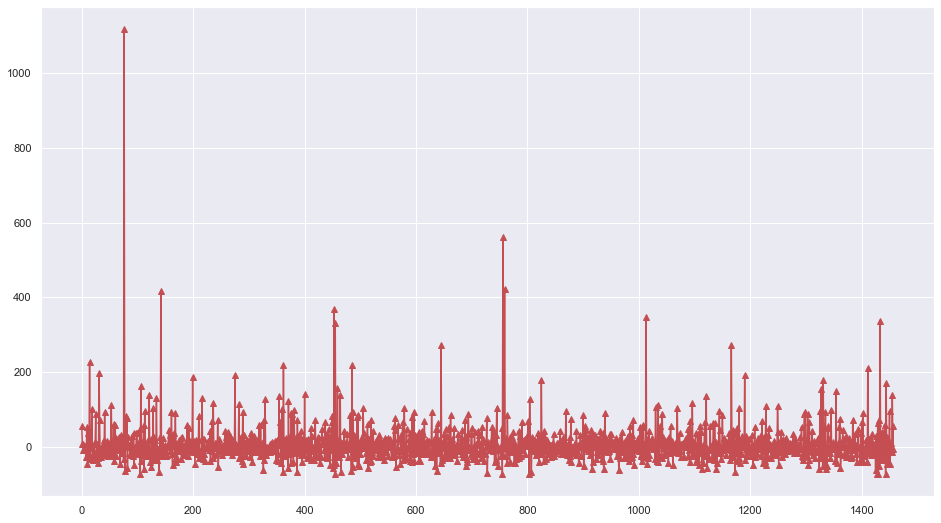

In [259]:
#plotting the error
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(final.index, final['error%'], marker='^', color='r')
plt.show()

In [260]:
MAPE = np.mean(final['error']/final['SalePrice'].astype(float))
MAPE

0.07382990748408595

In [261]:
bigerror = final[final['error%']<10]
bigerror.shape

(964, 156)

In [131]:
X_test = X_test.drop(['Predict'], axis=1)


In [132]:
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,max_depth=78) 
  
# fit the regressor with x and y data 
regressor=regressor.fit(X,train_labels)
xgb_pred = regressor.predict(X_test)
predict = regressor.predict(X_test)

In [133]:
X_test

,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtFinType1,BsmtFinType2,HeatingQC,BedroomAbvGr,KitchenQual,...,Fence_GdWo,Fence_MnPrv,Fence_None,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1460,1961,1961,3,3,3,3,2,3,2,3,...,0,1,0,0,0,1,0,0,1,0
1461,1958,1958,3,3,3,5,1,3,3,4,...,0,0,1,0,0,1,0,0,1,0
1462,1997,1998,3,3,4,6,1,4,3,3,...,0,1,0,0,0,1,0,0,1,0
1463,1998,1998,3,3,3,6,1,5,3,4,...,0,0,1,0,0,1,0,0,1,0
1464,1992,1992,4,3,4,5,1,5,2,4,...,0,0,1,0,0,1,0,0,1,0
1465,1993,1994,3,3,4,1,1,4,3,3,...,0,0,1,0,0,1,0,0,1,0
1466,1992,2007,3,4,4,5,1,5,3,3,...,0,0,0,0,0,1,0,0,1,0
1467,1998,1998,3,3,4,1,1,4,3,3,...,0,0,1,0,0,1,0,0,1,0
1468,1990,1990,3,3,4,6,1,4,2,4,...,0,0,1,0,0,1,0,0,1,0


In [429]:
bigerror.to_csv("bigerror.csv")

In [134]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenP

In [135]:
testdata = pd.read_csv("test.csv")


In [136]:
testdata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [137]:
poolarea = pd.merge(bigerror, testdata, on = "Id", how='left')

In [449]:
bigerror

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Predict,SalePrice,error,error%
0,1461,16.610808,14.551221,6,4.677073,1958,1958,14.607283,3,3,...,0,1,0,0,1,0,164192.187500,105000,59192.187500,56.373512
9,1470,8.574959,12.664874,7,3.989638,1999,1999,0.000000,4,3,...,0,1,0,0,1,0,191594.515625,126000,65594.515625,52.059139
12,1473,8.169235,10.810801,6,4.677073,1975,1975,0.000000,3,3,...,0,1,0,0,1,0,148919.390625,105500,43419.390625,41.155820
14,1475,18.902372,14.323659,9,3.989638,2009,2010,17.721067,5,3,...,1,0,0,0,0,1,386734.531250,120000,266734.531250,222.278776
18,1479,19.714126,14.556300,9,3.989638,2003,2004,42.215697,5,3,...,0,1,0,0,1,0,480717.250000,259000,221717.250000,85.605116
25,1486,14.008495,14.995360,8,3.989638,1998,1998,14.992320,4,3,...,0,1,0,0,1,0,346267.437500,185088,161179.437500,87.082597
31,1492,10.914782,14.721142,6,4.677073,1974,2002,21.698430,3,4,...,0,1,1,0,0,0,181528.343750,67500,114028.343750,168.930880
32,1493,17.067704,14.371475,8,3.989638,1993,1993,29.874464,4,3,...,0,1,0,0,1,0,296796.906250,169000,127796.906250,75.619471
41,1502,13.602783,14.322812,8,3.989638,2010,2010,0.000000,4,3,...,1,0,0,0,0,1,298984.968750,147110,151874.968750,103.239052
53,1514,15.044952,13.721843,5,5.345039,1952,2002,22.290040,4,3,...,0,1,0,0,1,0,179427.843750,84900,94527.843750,111.340216


In [450]:
poolarea.shape

(191, 335)

In [455]:
poolarea[poolarea['Fence']!=0]


,Id,LotFrontage_x,LotArea_x,OverallQual_x,OverallCond_x,YearBuilt_x,YearRemodAdd_x,MasVnrArea_x,ExterQual_x,ExterCond_x,...,ScreenPorch_y,PoolArea,PoolQC,Fence,MiscFeature,MiscVal_y,MoSold,YrSold,SaleType,SaleCondition
0,1461,16.610808,14.551221,6,4.677073,1958,1958,14.607283,3,3,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1470,8.574959,12.664874,7,3.989638,1999,1999,0.000000,4,3,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal
2,1473,8.169235,10.810801,6,4.677073,1975,1975,0.000000,3,3,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
3,1475,18.902372,14.323659,9,3.989638,2009,2010,17.721067,5,3,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1479,19.714126,14.556300,9,3.989638,2003,2004,42.215697,5,3,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
5,1486,14.008495,14.995360,8,3.989638,1998,1998,14.992320,4,3,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1492,10.914782,14.721142,6,4.677073,1974,2002,21.698430,3,4,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
7,1493,17.067704,14.371475,8,3.989638,1993,1993,29.874464,4,3,...,0,0,NaN,GdPrv,NaN,0,4,2010,WD,Abnorml
8,1502,13.602783,14.322812,8,3.989638,2010,2010,0.000000,4,3,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
9,1514,15.044952,13.721843,5,5.345039,1952,2002,22.290040,4,3,...,0,0,NaN,NaN,NaN,0,1,2010,Oth,Abnorml


In [459]:
poolarea['FireplaceQu']

KeyError: 'FireplaceQu'